## Causal Tracing

Preliminary experiemnts to determine type system knowledge in Code LLMs

## Loading models with Rome
modified the rome repo to support star/santacoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re, json
import torch, numpy
from collections import defaultdict

from model_utils import *
CACHE_DIR = "/scratch/lucchetti.f/models/"
os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR

import sys
sys.path.append('~/rome')

DATA_DIR = 'data'
from myrome.experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap
)
from myrome.experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
    trace_with_patch,
    trace_important_states,
    calculate_hidden_flow
)
from myrome.dsets import KnownsDataset
from myrome.util.generate import generate_fast, generate_interactive
from model_utils import print_formatted

## check has GPTBigCodeConfig
from transformers import GPTBigCodeConfig

torch.set_grad_enabled(False)

/home/lucchetti.f/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "bigcode/santacoder"  
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=True, # set false and provide device=INT for cuda device
    torch_dtype=(torch.float16 if "20b" in model_name else None),
    trust_remote_code=True
)
mt.tokenizer.pad_token = mt.tokenizer.eos_token

In [27]:
## test vanilla inference
predict_token(
    mt,
    ['int x ='],
    return_p=True,
)

([' '], tensor([0.6387], device='cuda:0'))

In [3]:
check_devs()
# mt.model

0 / 34079899648 used for device 0, reserved 0


## Preliminary explorations

In [8]:
mod = "EleutherAI/gpt-j-6B"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
gmt = ModelAndTokenizer(
    mod,
    low_cpu_mem_usage=True,
    torch_dtype=(torch.float16 if "20b" in mod else None),
    trust_remote_code=True
)

In [ ]:
gmt.tokenizer.pad_token = " "

prompts = [
"Megan Rapinoe plays the sport of", "The Space Needle is in the city of"
]

text = generate_fast(gmt.model, gmt.tokenizer, prompts)
text

In [68]:
prompts = [
'''static int func(){
    int x = 0;
    int y = 1;
    int z =''',
'''static String func(){
    String x = "x";
    String y = "y";
    String z ='''
]

text = generate_fast(mt.model, mt.tokenizer, prompts, max_out_len=50)
print_formatted(prompts, text)

## Prompt 0:
static int func(){
    int x = 0;
    int y = 1;
    int z =
## Gen 0:
static int func(){
    int x = 0;
    int y = 1;
    int z = x y y y y y y y y y y y y y y y y y y y
    return x + y + z;

## Prompt 1:
static String func(){
    String x = "x";
    String y = "y";
    String z =
## Gen 1:
static String func(){
    String x = "x";
    String y = "y";
    String z = " + " + " + " " + + + + +
    String x = "x";
    String y = "y";
   



In [69]:
prompts = [
'''static int func(){
    int x = 0;
    int y = 1;
    int hello =''',
'''static String func(){
    String x = "x";
    String y = "y";
    String hello ='''
]

text = generate_fast(mt.model, mt.tokenizer, prompts, max_out_len=50)
print_formatted(prompts, text)

## Prompt 0:
static int func(){
    int x = 0;
    int y = 1;
    int hello =
## Gen 0:
static int func(){
    int x = 0;
    int y = 1;
    int hello = 11;
}
class C{
class D { { { { { { { { { { { { { { {

## Prompt 1:
static String func(){
    String x = "x";
    String y = "y";
    String hello =
## Gen 1:
static String func(){
    String x = "x";
    String y = "y";
    String hello = x";
    return;;
 
return x;;
 
}
<fim-prefix>import java.util.Scanner;
public class



In [71]:
prompts = [
'''static int func(){
    int x = 0;
    return x +''',
'''static String func(){
    String x = "x";
    return x +'''
]

text = generate_fast(mt.model, mt.tokenizer, prompts, max_out_len=50)
print_formatted(prompts, text)

## Prompt 0:
static int func(){
    int x = 0;
    return x +
## Gen 0:
static int func(){
    int x = 0;
    return x + ;}";"
 
 
 
public static int f((((111111111111111111111

## Prompt 1:
static String func(){
    String x = "x";
    return x +
## Gen 1:
static String func(){
    String x = "x";
    return x + " + " + " + " " " " " " " " " " ;
    // String s = "s";
    // // return s.substring(0,



In [74]:
prompts = [
'''static int func(){
    int x = 0;
    if(x < 10){
        x++;
    }else{
        return x -'''
]

text = generate_fast(mt.model, mt.tokenizer, prompts, max_out_len=50)
print_formatted(prompts, text)

## Prompt 0:
static int func(){
    int x = 0;
    if(x < 10){
        x++;
    }else{
        return x -
## Gen 0:
static int func(){
    int x = 0;
    if(x < 10){
        x++;
    }else{
        return x - 1;
    }
    return x;
  }
 <fim-prefix><fim-suffix>    }
        //



## Examining traces

In [ ]:
from trace_model import ModelLoader


tm = ModelLoader(model_name, preloaded_model= mt.model)
prompts = ["int x ="]

txt, ret_dict = tm.generate(
    prompts,
    max_out_len=6,
    argmax_greedy= True,
    debug = True,
    request_activations= [lm.layer_name_format.format(i) for i in range(5,10)],
    preloaded
)
txt, ret_dict

## Scanning + tracing locations for typing knowledge based on Exploration Dataset

`TODO` gather exploration dataset
This is just some skeleton code to test Rome compatibility

### Add noise based on dataset of known facts

In [75]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 2 elements
Using noise level 0.028766443021595478


In [76]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

## Test impact on a prompt

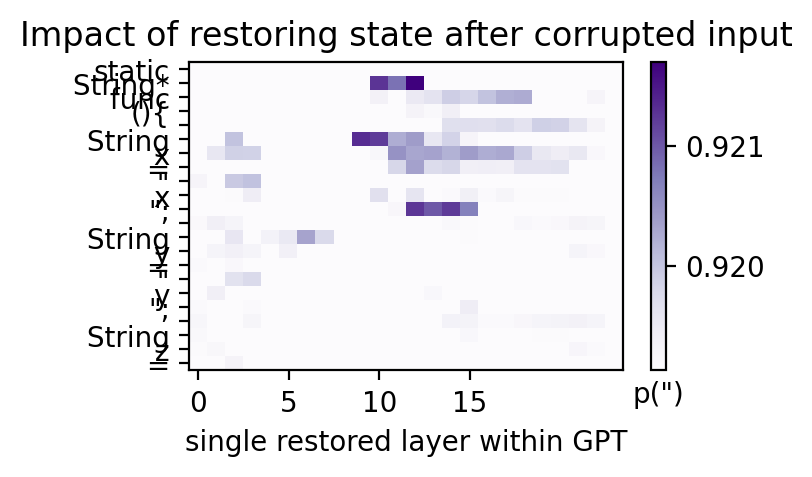

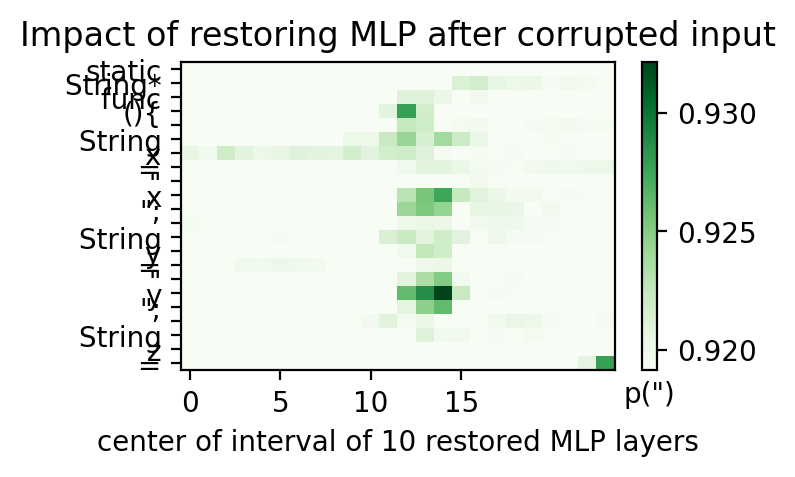

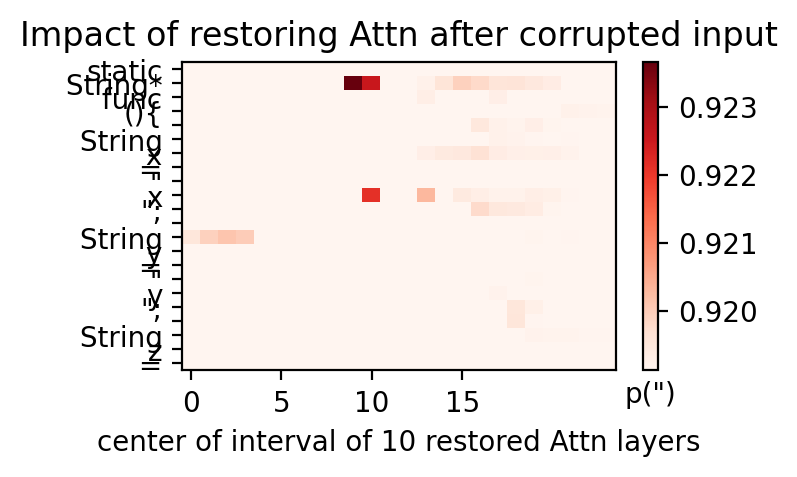

In [79]:
prompt = [
'''static String func(){
    String x = "x";
    String y = "y";
    String z =''']
plot_all_flow(mt, prompt[0], noise=noise_level)

In [ ]:
# for knowledge in knowns[:5]:
#     plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)